# End-to-end workflow

This notebook demonstrates an end-to-end workflow using `ROMS-Tools` to prepare inputs and analyze outputs for a ROMS-MARBL simulation.

We will create the following components:

- Grid  
- Initial conditions
- Surface forcing   
- Boundary forcing  
- River forcing  
- CDR (Carbon Dioxide Removal) forcing  

After generating these inputs, we will run a ROMS-MARBL simulation and perform a basic analysis of the model output using `ROMS-Tools`.

<div class="alert alert-info">

Note

This notebook is intended to provide a high-level overview. For detailed explanations, see the example notebooks that explore each step individually.
</div>

## Running the notebook

To run this notebook, make sure you have the required dependencies installed. You can set them up in one of the following ways (see also [this installation page](https://roms-tools.readthedocs.io/en/latest/installation.html)):

1. **Install from PyPI**  
   ```bash
   pip install roms-tools[notebooks]
   ```
2. **Install from GitHub**
   ```bash
   cd roms-tools
   conda env create -f ci/environment-with-xesmf.yml
   conda activate romstools-test
   pip install ".[notebooks]"
   ```
3. **Add missing packages to an existing roms-tools installation**
   ```bash
   pip install copernicusmarine gdown podman
   ```

In addition, `podman` must be installed to run ROMS in a container. See the installation instructions [here](https://podman.io/docs/installation).

## Creating the input files with `ROMS-Tools`

Let's prepare our input data for January 2012.

In [1]:
from datetime import datetime
start_time = datetime(2012, 1, 1)
end_time = datetime(2012, 1, 31)

We will save the input datasets to a designated target directory. Feel free to modify the target path!

In [2]:
from pathlib import Path

In [3]:
target_dir = Path("./ROMS_TOOLS_INPUT_DATA")

In [4]:
# Create the directory if it doesn't exist
target_dir.mkdir(exist_ok=True)

### Grid

In [6]:
from roms_tools import Grid

Let's make a new domain in the Gulf of Mexico, with horizontal resolution of 20km and 20 vertical layers.

In [7]:
%%time

grid = Grid(
    nx=100,  # number of grid points in x-direction
    ny=80,  # number of grid points in y-direction
    size_x=2000,  # domain size in x-direction (in km)
    size_y=1600,  # domain size in y-direction (in km)
    center_lon=-89,  # longitude of the center of the domain
    center_lat=24,  # latitude of the center of the domain
    rot=0,  # rotation of the grid (in degrees)
    N=20,  # number of vertical layers
)

CPU times: user 1.12 s, sys: 36.3 ms, total: 1.16 s
Wall time: 1.18 s


<div class="alert alert-info">

Note

This example uses the default ETOPO5 bathymetry, with a horizontal resolution of 1/12°. This is sufficient for our 20 km grid, but for higher-resolution grids, consider using SRTM15. For more details on topography source data, see [this page](https://roms-tools.readthedocs.io/en/latest/grid.html#Topography-source-data).

</div>

Let’s examine the grid variables that were created, which can be found in the `xarray.Dataset` returned by the `.ds` attribute.

In [8]:
grid.ds

<xarray.Dataset> Size: 894kB
Dimensions:       (eta_rho: 82, xi_rho: 102, xi_u: 101, eta_v: 81,
                   eta_coarse: 42, xi_coarse: 52, s_rho: 20, s_w: 21)
Coordinates:
    lat_rho       (eta_rho, xi_rho) float64 67kB 16.43 16.44 ... 30.94 30.93
    lon_rho       (eta_rho, xi_rho) float64 67kB 261.6 261.8 ... 281.3 281.5
    lat_u         (eta_rho, xi_u) float64 66kB 16.44 16.45 16.46 ... 30.95 30.93
    lon_u         (eta_rho, xi_u) float64 66kB 261.7 261.9 262.1 ... 281.2 281.4
    lat_v         (eta_v, xi_rho) float64 66kB 16.52 16.53 16.55 ... 30.85 30.84
    lon_v         (eta_v, xi_rho) float64 66kB 261.6 261.8 262.0 ... 281.3 281.5
    lat_coarse    (eta_coarse, xi_coarse) float64 17kB 16.34 16.36 ... 31.01
    lon_coarse    (eta_coarse, xi_coarse) float64 17kB 261.5 261.9 ... 281.6
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v, eta_coarse,
                                xi_coarse, s_rho, s_w
Data variables: (12/15)
    angle         (eta_rho, xi_rho) float64 67kB 0.06568 0.06568 ... -0.07345
    f             (eta_rho, xi_rho) float64 67kB 4.115e-05 ... 7.475e-05
    pm            (eta_rho, xi_rho) float64 67kB 5.038e-05 ... 5.038e-05
    pn            (eta_rho, xi_rho) float64 67kB 5.04e-05 5.04e-05 ... 5.04e-05
    spherical     |S1 1B b'T'
    mask_rho      (eta_rho, xi_rho) int32 33kB 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1
    ...            ...
    mask_coarse   (eta_coarse, xi_coarse) int32 9kB 0 0 0 0 0 0 ... 1 1 1 1 1 1
    h             (eta_rho, xi_rho) float64 67kB 5.0 5.0 5.0 ... 803.4 803.4
    sigma_r       (s_rho) float32 80B -0.975 -0.925 -0.875 ... -0.075 -0.025
    Cs_r          (s_rho) float32 80B -0.9579 -0.8615 ... -0.002245 -0.0002471
    sigma_w       (s_w) float32 84B -1.0 -0.95 -0.9 -0.85 ... -0.1 -0.05 0.0
    Cs_w          (s_w) float32 84B -1.0 -0.9114 -0.809 ... -0.0009921 0.0
Attributes: (12/13)
    title:                   ROMS grid created by ROMS-Tools
    roms_tools_version:      3.1.3.dev32+g91d580e67.d20250929
    size_x:                  2000
    size_y:                  1600
    center_lon:              -89
    center_lat:              24
    ...                      ...
    straddle:                False
    topography_source_name:  ETOPO5
    hmin:                    5.0
    theta_s:                 5.0
    theta_b:                 2.0
    hc:                      300.0

To visualize the grid we have just created, we can use the `.plot` method.

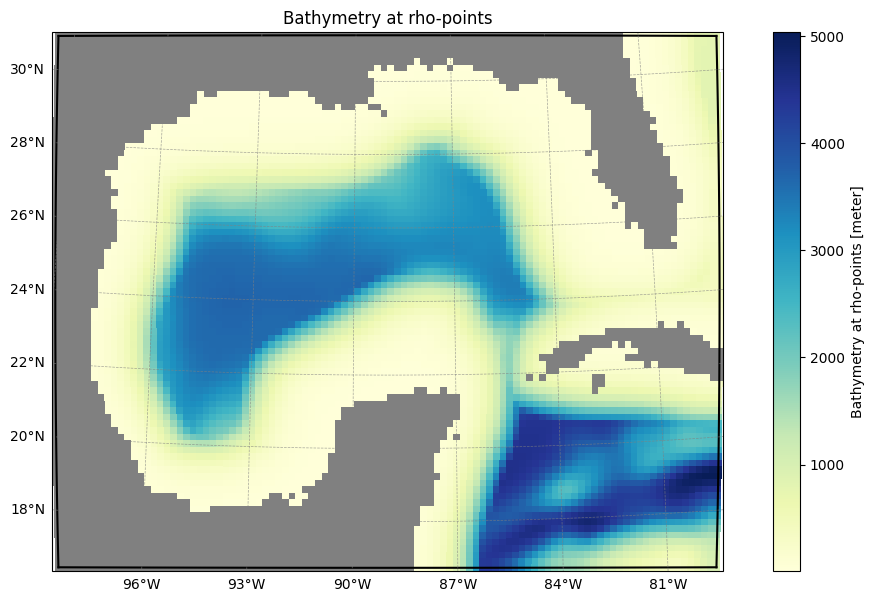

In [9]:
grid.plot()

We can save our grid variables as a netCDF file via the `.save` method.

In [10]:
%%time

grid.save(target_dir / "roms_grd.nc")

2025-09-29 13:35:41 - INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_grd.nc


CPU times: user 7.93 ms, sys: 2.48 ms, total: 10.4 ms
Wall time: 11 ms


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_grd.nc')]

We can also export the grid parameters to a YAML file. This gives us a more storage-effective way to save and share input data made with `ROMS-Tools`. The YAML file can be used to recreate the same object later.

In [11]:
yaml_filepath = target_dir / "roms_grd.yaml"
grid.to_yaml(yaml_filepath)

These are the contents of the written YAML file.

In [12]:
with open(yaml_filepath, "r") as file:
    file_contents = file.read()

# Print the contents
print(file_contents)

---
roms_tools_version: 3.1.3.dev32+g91d580e67.d20250929
---
Grid:
  nx: 100
  ny: 80
  size_x: 2000
  size_y: 1600
  center_lon: -89
  center_lat: 24
  rot: 0
  N: 20
  theta_s: 5.0
  theta_b: 2.0
  hc: 300.0
  topography_source:
    name: ETOPO5
  hmin: 5.0



You can find more information about creating, plotting, and saving grids [here](https://roms-tools.readthedocs.io/en/latest/grid.html).

### Initial Conditions

We want to prepare a simulation in which we run ROMS with MARBL biogeochemistry (BGC), so we need to prepare both physical and BGC initial conditions. We create physical and BGC initial conditions **together** because ROMS needs a **single** initial conditions file. We use

* **GLORYS data** to create our physical initial conditions, i.e., initial temperature, salinity, sea surface height, and velocities;
* a **unified biogeochemical (BGC) climatology** combining multiple observationally and model based sources to create our BGC initial conditions.

[Here](https://roms-tools.readthedocs.io/en/latest/datasets.html) you can find instruction on how to download these datasets. We have already completed these steps, and the datasets are locally available at the paths shown below.

In [13]:
glorys_path = "source-data/GoM_GLORYS_Jan2012.nc"

In [14]:
unified_bgc_path = "source-data/BGCdataset.nc"

With the source data in place, we can now generate the initial conditions.

In [15]:
from roms_tools import InitialConditions

In [16]:
%%time

initial_conditions = InitialConditions(
    grid=grid,
    ini_time=start_time,
    source={"name": "GLORYS", "path": glorys_path},
    bgc_source={
        "name": "UNIFIED",
        "path": unified_bgc_path,
        "climatology": True,
    },
    use_dask=True
)

2025-09-29 13:35:43 - INFO - Sea surface height will NOT be used to adjust depth coordinates.


CPU times: user 1.64 s, sys: 319 ms, total: 1.96 s
Wall time: 1.57 s


<div class="alert alert-info">

Note

In the cell above, we created our initial conditions with `use_dask = True`. This enables `Dask`, a Python library designated to facilitate scalable, out-of-memory data processing by distributing computations across multiple threads or processes. [Here](https://roms-tools.readthedocs.io/en/latest/using_dask.html) you can learn more about using `Dask` with `ROMS-Tools`.

</div>

The following variables were generated as part of the initial conditions.

In [17]:
initial_conditions.ds

<xarray.Dataset> Size: 25MB
Dimensions:      (ocean_time: 1, s_rho: 20, eta_rho: 82, xi_rho: 102,
                  xi_u: 101, eta_v: 81, s_w: 21)
Coordinates:
    abs_time     (ocean_time) datetime64[ns] 8B 2012-01-01
  * ocean_time   (ocean_time) float64 8B 3.787e+08
Dimensions without coordinates: s_rho, eta_rho, xi_rho, xi_u, eta_v, s_w
Data variables: (12/42)
    temp         (ocean_time, s_rho, eta_rho, xi_rho) float32 669kB dask.array<chunksize=(1, 20, 50, 50), meta=np.ndarray>
    salt         (ocean_time, s_rho, eta_rho, xi_rho) float32 669kB dask.array<chunksize=(1, 20, 50, 50), meta=np.ndarray>
    u            (ocean_time, s_rho, eta_rho, xi_u) float32 663kB dask.array<chunksize=(1, 20, 50, 50), meta=np.ndarray>
    v            (ocean_time, s_rho, eta_v, xi_rho) float32 661kB dask.array<chunksize=(1, 20, 50, 50), meta=np.ndarray>
    zeta         (ocean_time, eta_rho, xi_rho) float32 33kB 0.2544 ... 0.2846
    ubar         (ocean_time, eta_rho, xi_u) float32 33kB dask.array<chunksize=(1, 50, 50), meta=np.ndarray>
    ...           ...
    Lig          (ocean_time, s_rho, eta_rho, xi_rho) float32 669kB dask.array<chunksize=(1, 20, 50, 50), meta=np.ndarray>
    DIC_ALT_CO2  (ocean_time, s_rho, eta_rho, xi_rho) float32 669kB dask.array<chunksize=(1, 20, 50, 50), meta=np.ndarray>
    ALK_ALT_CO2  (ocean_time, s_rho, eta_rho, xi_rho) float32 669kB dask.array<chunksize=(1, 20, 50, 50), meta=np.ndarray>
    w            (ocean_time, s_w, eta_rho, xi_rho) float32 703kB 0.0 ... 0.0
    Cs_r         (s_rho) float32 80B -0.9579 -0.8615 ... -0.002245 -0.0002471
    Cs_w         (s_w) float32 84B -1.0 -0.9114 -0.809 ... -0.0009921 0.0
Attributes:
    title:                                ROMS initial conditions file create...
    roms_tools_version:                   3.1.3.dev32+g91d580e67.d20250929
    ini_time:                             2012-01-01 00:00:00
    model_reference_date:                 2000-01-01 00:00:00
    adjust_depth_for_sea_surface_height:  False
    source:                               GLORYS
    bgc_source:                           UNIFIED
    theta_s:                              5.0
    theta_b:                              2.0
    hc:                                   300.0

Here is a plot of the uppermost layer of the temperature field.

[########################################] | 100% Completed | 631.83 ms


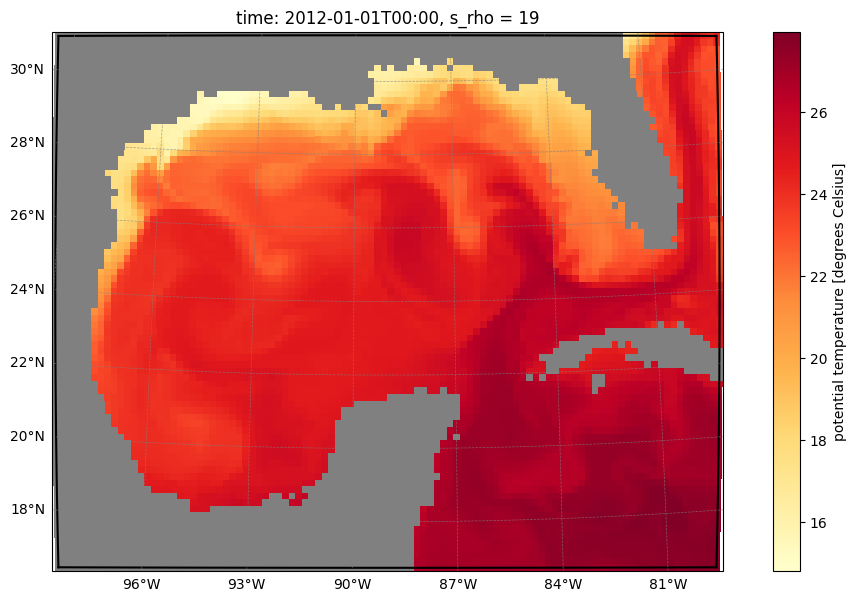

In [18]:
initial_conditions.plot("temp", s=-1)

We can also plot vertical sections of our initial conditions, for example alkalinity.

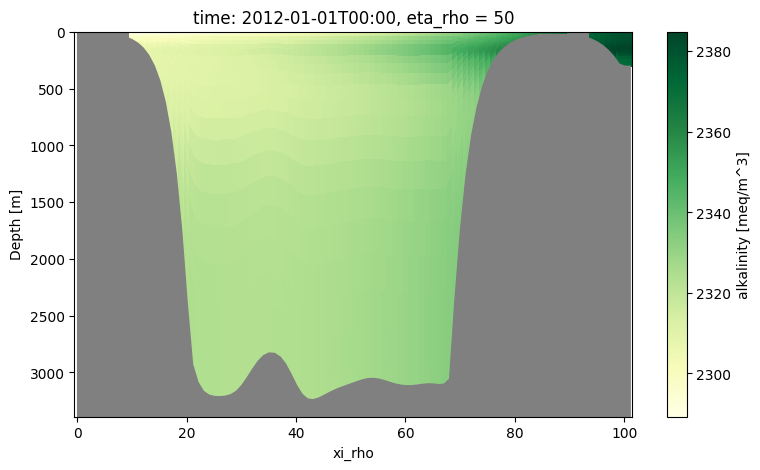

In [19]:
initial_conditions.plot("ALK", eta=50)

We can now save the dataset as a NetCDF and YAML file.

In [20]:
initial_conditions.save(target_dir / "roms_ini.nc")

2025-09-29 13:35:46 - INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_ini.nc


[########################################] | 100% Completed | 5.55 sms


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_ini.nc')]

In [21]:
initial_conditions.to_yaml(target_dir / "roms_ini.yaml")

You can find more information about creating, plotting, and saving initial conditions [here](https://roms-tools.readthedocs.io/en/latest/initial_conditions.html).

### Surface Forcing
Next, we create the surface forcing for our domain.

`ROMS-Tools` can create two types of surface forcing:

* **physical surface forcing**, e.g., 10m wind, shortwave radiation, and air temperature at 2m;
* **biogeochemical (BGC) surface forcing**, e.g., atmospheric pCO2.

Unlike initial conditions data, ROMS can read multiple surface forcing files, so we create these two types separately.

In [22]:
from roms_tools import SurfaceForcing

#### Physical Surface Forcing

In this subsection, we use ERA5 data to generate the physical surface forcing. With ROMS-Tools, ERA5 can be streamed directly from the cloud, so you don’t need to pre-download the source data or provide a local path (though you can still do so if you prefer). See [here](https://roms-tools.readthedocs.io/en/latest/surface_forcing.html#Physical-surface-forcing) for more details on source data options.

In [25]:
%%time

surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "ERA5"},
    type="physics",
    use_dask=True
)

2025-09-29 13:46:40 - INFO - No path specified for ERA5 source; defaulting to ARCO ERA5 dataset on Google Cloud.
2025-09-29 13:47:58 - INFO - Data will be interpolated onto the fine grid. Remember to set `interp_frc = 0` in your `bulk_frc.opt` ROMS option file.


CPU times: user 1min 20s, sys: 6.95 s, total: 1min 27s
Wall time: 1min 32s


<div class="alert alert-info">

Note

For an explanation of the info message about interpolation onto the fine versus coarse grid, see this [page](https://roms-tools.readthedocs.io/en/latest/surface_forcing.html#Fine-vs.-coarse-grid).

</div>

These are the physical surface forcing variables that were created.

In [26]:
surface_forcing.ds

<xarray.Dataset> Size: 169MB
Dimensions:   (time: 721, eta_rho: 82, xi_rho: 102)
Coordinates:
    abs_time  (time) datetime64[ns] 6kB 2012-01-01 ... 2012-01-31
  * time      (time) float64 6kB 4.383e+03 4.383e+03 ... 4.413e+03 4.413e+03
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    uwnd      (time, eta_rho, xi_rho) float32 24MB dask.array<chunksize=(1, 82, 102), meta=np.ndarray>
    vwnd      (time, eta_rho, xi_rho) float32 24MB dask.array<chunksize=(1, 82, 102), meta=np.ndarray>
    swrad     (time, eta_rho, xi_rho) float32 24MB dask.array<chunksize=(1, 82, 102), meta=np.ndarray>
    lwrad     (time, eta_rho, xi_rho) float32 24MB dask.array<chunksize=(1, 82, 102), meta=np.ndarray>
    Tair      (time, eta_rho, xi_rho) float32 24MB dask.array<chunksize=(1, 82, 102), meta=np.ndarray>
    rain      (time, eta_rho, xi_rho) float32 24MB dask.array<chunksize=(1, 82, 102), meta=np.ndarray>
    qair      (time, eta_rho, xi_rho) float32 24MB dask.array<chunksize=(1, 82, 102), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    3.1.3.dev32+g91d580e67.d20250929
    start_time:            2012-01-01 00:00:00
    end_time:              2012-01-31 00:00:00
    source:                ERA5
    correct_radiation:     True
    wind_dropoff:          False
    use_coarse_grid:       False
    model_reference_date:  2000-01-01 00:00:00
    type:                  physics

Here is a plot of the zonal wind at the first created time stamp.

[########################################] | 100% Completed | 1.25 sms


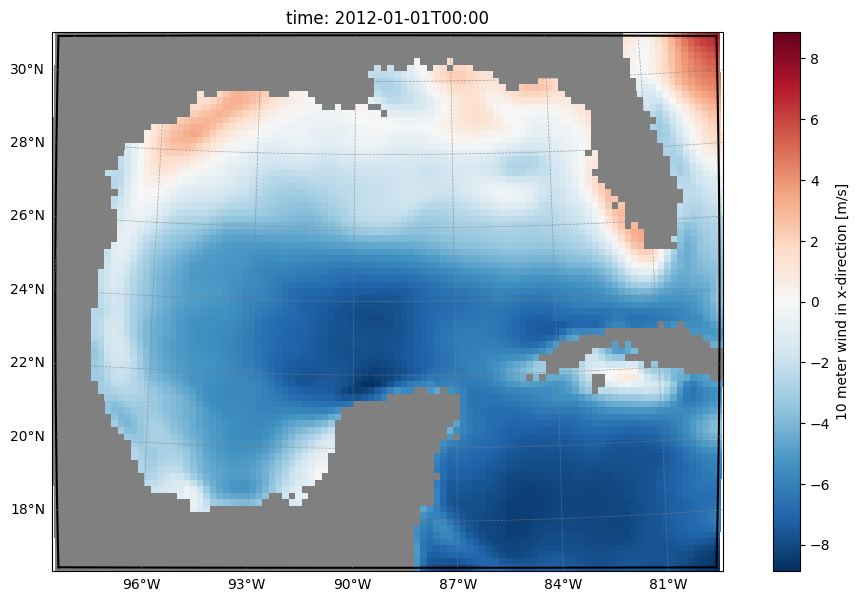

In [27]:
surface_forcing.plot("uwnd", time=0)

Let's save our physical surface forcing to NetCDF and YAML files.

In [28]:
surface_forcing.save(target_dir / "roms_frc.nc")

2025-09-29 13:48:58 - INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_frc_201201.nc


[########################################] | 100% Completed | 19m 22s


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_frc_201201.nc')]

In [29]:
surface_forcing.to_yaml(target_dir / "roms_frc.yaml")

#### Biogeochemical (BGC) Surface Forcing
We now create BGC surface forcing.

In [30]:
%%time

bgc_surface_forcing = SurfaceForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    source={"name": "UNIFIED", "path": unified_bgc_path, "climatology": True},
    type="bgc",
    use_dask=True
)

2025-09-29 14:09:56 - INFO - Data will be interpolated onto the grid coarsened by factor 2. Remember to set `interp_frc = 1` in your `bgc.opt` ROMS option file.


CPU times: user 79 ms, sys: 4.52 ms, total: 83.5 ms
Wall time: 86.4 ms


Here are the BGC surface variables that were created.

In [31]:
bgc_surface_forcing.ds

<xarray.Dataset> Size: 630kB
Dimensions:       (time: 12, eta_rho: 42, xi_rho: 52)
Coordinates:
    month         (time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    abs_time      (time) datetime64[ns] 96B 2000-01-16T12:00:00 ... 2000-12-1...
    pco2_time     (time) float64 96B 15.5 45.0 74.5 105.0 ... 288.5 319.0 349.5
    iron_time     (time) float64 96B 15.5 45.0 74.5 105.0 ... 288.5 319.0 349.5
    dust_time     (time) float64 96B 15.5 45.0 74.5 105.0 ... 288.5 319.0 349.5
    nox_time      (time) float64 96B 15.5 45.0 74.5 105.0 ... 288.5 319.0 349.5
    nhy_time      (time) float64 96B 15.5 45.0 74.5 105.0 ... 288.5 319.0 349.5
Dimensions without coordinates: time, eta_rho, xi_rho
Data variables:
    pco2_air      (time, eta_rho, xi_rho) float32 105kB dask.array<chunksize=(6, 42, 52), meta=np.ndarray>
    dust          (time, eta_rho, xi_rho) float32 105kB dask.array<chunksize=(12, 42, 52), meta=np.ndarray>
    iron          (time, eta_rho, xi_rho) float32 105kB dask.array<chunksize=(6, 42, 52), meta=np.ndarray>
    nox           (time, eta_rho, xi_rho) float32 105kB dask.array<chunksize=(6, 42, 52), meta=np.ndarray>
    nhy           (time, eta_rho, xi_rho) float32 105kB dask.array<chunksize=(6, 42, 52), meta=np.ndarray>
    pco2_air_alt  (time, eta_rho, xi_rho) float32 105kB dask.array<chunksize=(6, 42, 52), meta=np.ndarray>
Attributes:
    title:                 ROMS surface forcing file created by ROMS-Tools
    roms_tools_version:    3.1.3.dev32+g91d580e67.d20250929
    start_time:            2012-01-01 00:00:00
    end_time:              2012-01-31 00:00:00
    source:                UNIFIED
    correct_radiation:     True
    wind_dropoff:          False
    use_coarse_grid:       True
    model_reference_date:  2000-01-01 00:00:00
    type:                  bgc
    climatology:           True

Let's plot atmospheric pCO2, which is one of the BGC surface forcings.

[########################################] | 100% Completed | 103.16 ms


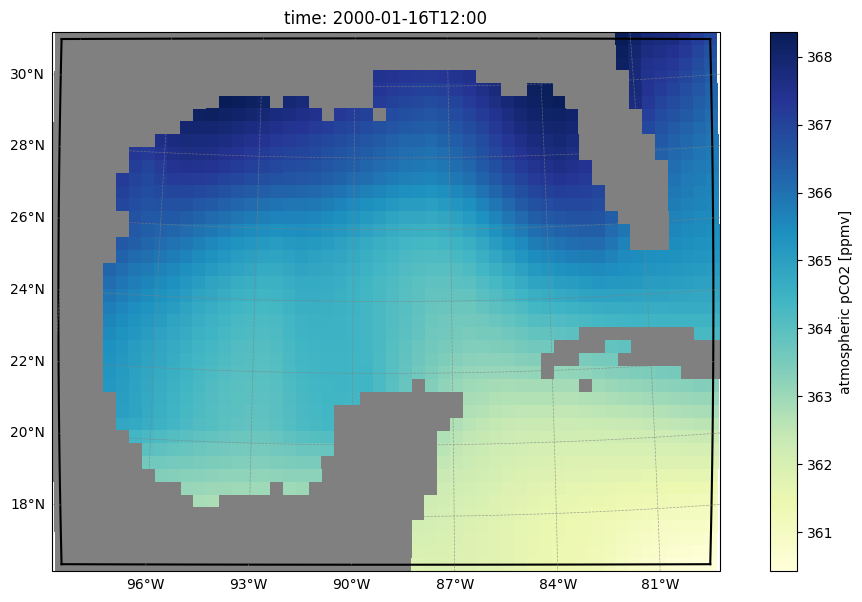

In [32]:
bgc_surface_forcing.plot("pco2_air", time=0)

Finally, we save our BGC surface forcing to NetCDF and YAML files.

In [33]:
bgc_surface_forcing.save(target_dir /"roms_frc_bgc.nc")

2025-09-29 14:10:00 - INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_frc_bgc_clim.nc


[########################################] | 100% Completed | 106.55 ms


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_frc_bgc_clim.nc')]

In [34]:
bgc_surface_forcing.to_yaml(target_dir / "roms_frc_bgc.yaml")

You can find more information about creating, plotting, and saving surface forcing [here](https://roms-tools.readthedocs.io/en/latest/surface_forcing.html).

### Boundary Forcing
In this subsection, we create the boundary forcing (or, equivalently, the open boundary conditions).

`ROMS-Tools` can create two types of boundary forcing:

* **physical boundary forcing** like temperature, salinity, velocities, and sea surface height;
* **biogeochemical (BGC) boundary forcing** like alkalinity, dissolved inorganic phosphate, etc.

As with surface forcing, ROMS accepts multiple boundary forcing files, so we create these two types separately.

In [35]:
from roms_tools import BoundaryForcing

#### Physical boundary forcing

We use the same GLORYS data as above to create our physical boundary forcing. Since the western boundary of our Gulf of Mexico domain lies entirely on land, we can exclude the western boundary in the following.

In [36]:
%%time

boundary_forcing = BoundaryForcing(
    grid=grid,
    boundaries={
        "south": True,
        "east": True,
        "north": True,
        "west": False,   # western boundary excluded
    },
    start_time=start_time,
    end_time=end_time,
    source={"name": "GLORYS", "path": glorys_path},
    type="physics",
    use_dask=True
)

2025-09-29 14:10:17 - INFO - Sea surface height will NOT be used to adjust depth coordinates.
2025-09-29 14:10:17 - WARNING - The southern boundary is divided by land. It would be safer (but slower and more memory-intensive) to use `apply_2d_horizontal_fill = True`.
2025-09-29 14:10:17 - WARNING - The eastern boundary is divided by land. It would be safer (but slower and more memory-intensive) to use `apply_2d_horizontal_fill = True`.


CPU times: user 1.02 s, sys: 238 ms, total: 1.26 s
Wall time: 1.12 s


<div class="alert alert-info">

Note

For an explanation of the warning message about the division of boundaries by land, see this [page](https://roms-tools.readthedocs.io/en/latest/boundary_forcing.html#1D-versus-2D-horizontal-fill).

</div>

Here are the physical boundary forcing variables that were created.

In [37]:
boundary_forcing.ds

<xarray.Dataset> Size: 3MB
Dimensions:     (bry_time: 31, s_rho: 20, xi_u: 101, xi_rho: 102, eta_rho: 82,
                 eta_v: 81)
Coordinates:
    abs_time    (bry_time) datetime64[ns] 248B 2012-01-01 ... 2012-01-31
  * bry_time    (bry_time) float64 248B 4.383e+03 4.384e+03 ... 4.413e+03
Dimensions without coordinates: s_rho, xi_u, xi_rho, eta_rho, eta_v
Data variables: (12/21)
    u_south     (bry_time, s_rho, xi_u) float32 250kB dask.array<chunksize=(1, 20, 101), meta=np.ndarray>
    v_south     (bry_time, s_rho, xi_rho) float32 253kB dask.array<chunksize=(1, 20, 102), meta=np.ndarray>
    temp_south  (bry_time, s_rho, xi_rho) float32 253kB dask.array<chunksize=(1, 20, 102), meta=np.ndarray>
    salt_south  (bry_time, s_rho, xi_rho) float32 253kB dask.array<chunksize=(1, 20, 102), meta=np.ndarray>
    zeta_south  (bry_time, xi_rho) float32 13kB dask.array<chunksize=(1, 102), meta=np.ndarray>
    ubar_south  (bry_time, xi_u) float32 13kB dask.array<chunksize=(1, 101), meta=np.ndarray>
    ...          ...
    v_north     (bry_time, s_rho, xi_rho) float32 253kB dask.array<chunksize=(1, 20, 102), meta=np.ndarray>
    temp_north  (bry_time, s_rho, xi_rho) float32 253kB dask.array<chunksize=(1, 20, 102), meta=np.ndarray>
    salt_north  (bry_time, s_rho, xi_rho) float32 253kB dask.array<chunksize=(1, 20, 102), meta=np.ndarray>
    zeta_north  (bry_time, xi_rho) float32 13kB dask.array<chunksize=(1, 102), meta=np.ndarray>
    ubar_north  (bry_time, xi_u) float32 13kB dask.array<chunksize=(1, 101), meta=np.ndarray>
    vbar_north  (bry_time, xi_rho) float32 13kB dask.array<chunksize=(1, 102), meta=np.ndarray>
Attributes:
    title:                                ROMS boundary forcing file created ...
    roms_tools_version:                   3.1.3.dev32+g91d580e67.d20250929
    start_time:                           2012-01-01 00:00:00
    end_time:                             2012-01-31 00:00:00
    source:                               GLORYS
    model_reference_date:                 2000-01-01 00:00:00
    apply_2d_horizontal_fill:             False
    adjust_depth_for_sea_surface_height:  False
    theta_s:                              5.0
    theta_b:                              2.0
    hc:                                   300.0

Let's plot meridional velocity at the southern boundary for the first available time stamp.

[########################################] | 100% Completed | 107.41 ms


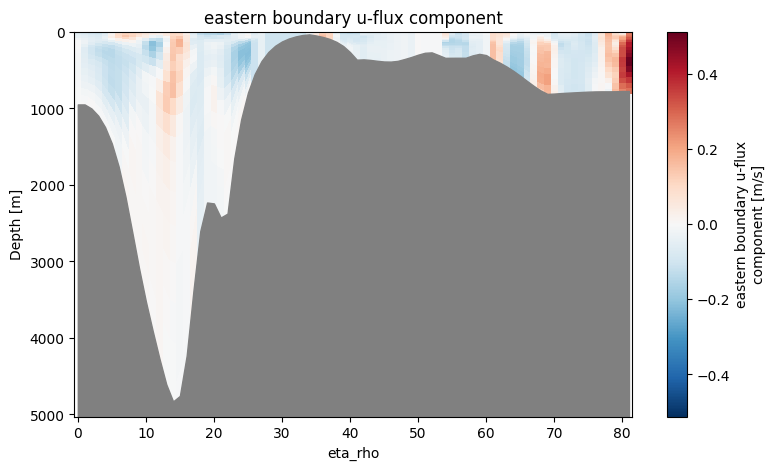

In [38]:
boundary_forcing.plot("u_east", time=0)

Finally, we save our physical boundary forcing variables to NetCDF and YAML files.

In [39]:
boundary_forcing.save(target_dir / "roms_bry.nc")

2025-09-29 14:10:24 - INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_bry_201201.nc


[########################################] | 100% Completed | 4.92 sms


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_bry_201201.nc')]

In [40]:
boundary_forcing.to_yaml(target_dir / "roms_bry.yaml")

#### Biogeochemical (BGC) boundary forcing
We now create BGC boundary forcing. The BGC variables are interpolated from the same unified BGC climatology as above.

In [41]:
%%time

bgc_boundary_forcing = BoundaryForcing(
    grid=grid,
    boundaries={
        "south": True,
        "east": True,
        "north": True,
        "west": False,   # western boundary excluded
    },
    start_time=start_time,
    end_time=end_time,
    source={"name": "UNIFIED", "path": unified_bgc_path, "climatology": True},
    type="bgc",
    use_dask=True
)

2025-09-29 14:10:33 - INFO - Sea surface height will NOT be used to adjust depth coordinates.


CPU times: user 1.53 s, sys: 33.3 ms, total: 1.57 s
Wall time: 1.59 s


[########################################] | 100% Completed | 106.90 ms


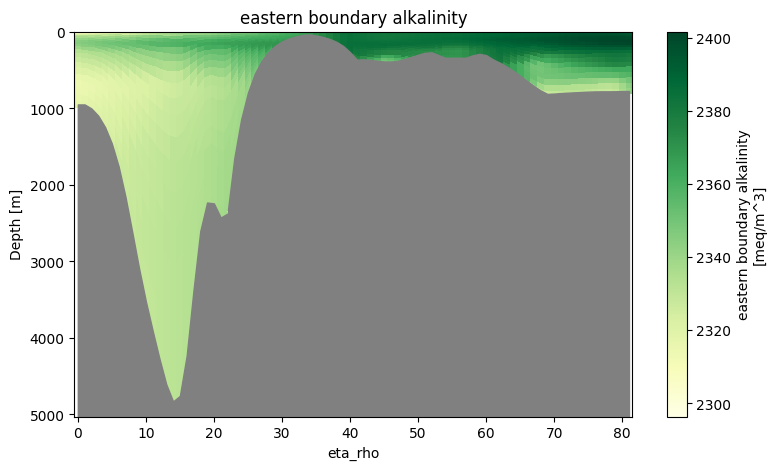

In [42]:
bgc_boundary_forcing.plot("ALK_east", time=0)

In [43]:
bgc_boundary_forcing.save(target_dir / "roms_bry_bgc.nc")

2025-09-29 14:10:37 - INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_bry_bgc_clim.nc


[########################################] | 100% Completed | 8.49 ss


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_bry_bgc_clim.nc')]

In [44]:
bgc_boundary_forcing.to_yaml(target_dir / "roms_bry_bgc.yaml")

You can find more information about creating, plotting, and saving boundary forcing [here](https://roms-tools.readthedocs.io/en/latest/boundary_forcing.html).

### River Forcing

In this subsection, we create the river forcing.

In [45]:
from roms_tools import RiverForcing

In [46]:
%time
river_forcing = RiverForcing(
    grid=grid,
    start_time=start_time,
    end_time=end_time,
    include_bgc=True
)

2025-09-29 14:10:50 - INFO - No river indices provided. Identify all rivers within the ROMS domain and assign each of them to the nearest coastal point.


CPU times: user 3 μs, sys: 9 μs, total: 12 μs
Wall time: 25 μs


2025-09-29 14:10:50 - INFO - Compute climatology for river forcing.
2025-09-29 14:10:50 - WARNING - NaNs detected in 'river_volume' and set to zero. This may indicate missing river data and affect model accuracy. 


Here are the river forcing variables that were created.

In [47]:
river_forcing.ds

<xarray.Dataset> Size: 134kB
Dimensions:           (ntracers: 34, river_time: 12, nriver: 34, eta_rho: 82,
                       xi_rho: 102)
Coordinates:
    tracer_name       (ntracers) <U11 1kB 'temp' 'salt' ... 'diazP' 'diazFe'
    tracer_unit       (ntracers) <U15 2kB 'degrees Celsius' 'PSU' ... 'mmol/m^3'
    tracer_long_name  (ntracers) <U43 6kB 'potential temperature' ... 'diazot...
    month             (river_time) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
    river_name        (nriver) object 272B 'Mississippi' ... 'FisheatingCree'
  * nriver            (nriver) int64 272B 1 2 3 4 5 6 7 ... 28 29 30 31 32 33 34
    abs_time          (river_time) datetime64[ns] 96B 2000-01-16 ... 2000-12-15
  * river_time        (river_time) float64 96B 15.0 45.0 74.0 ... 319.0 349.0
Dimensions without coordinates: ntracers, eta_rho, xi_rho
Data variables:
    river_volume      (river_time, nriver) float32 2kB 2.12e+04 ... 1.927
    river_tracer      (river_time, ntracers, nriver) float32 55kB 17.0 ... 1....
    river_index       (eta_rho, xi_rho) float32 33kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    river_fraction    (eta_rho, xi_rho) float32 33kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    climatology:  True

Let's make a plot of the river locations.

2025-09-29 14:10:54 - WARNING - Only the first 20 rivers will be plotted (received 34).


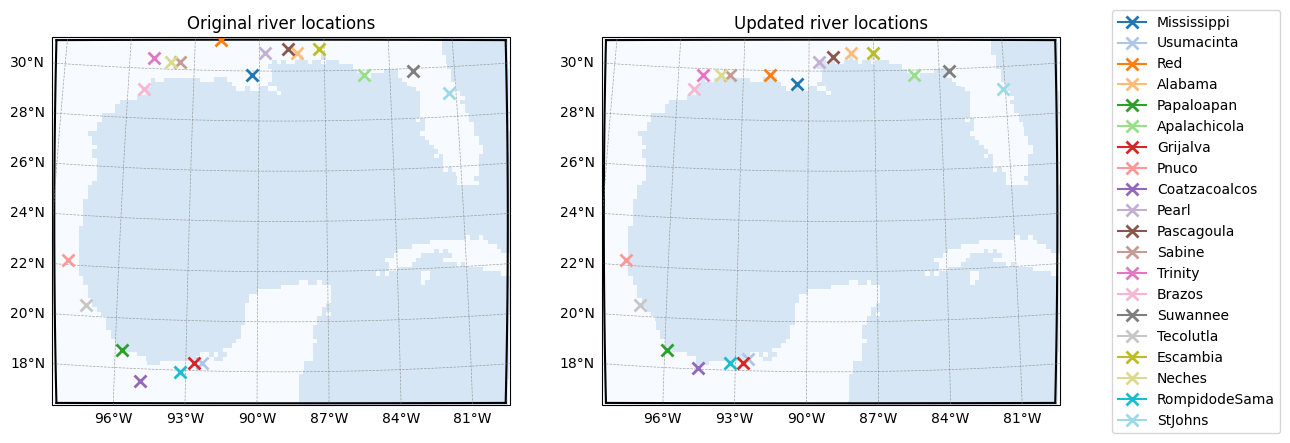

In [48]:
river_forcing.plot_locations()

The left plot shows the original river locations from the Dai and Trenberth global river dataset mapped onto the ROMS domain, many of which are off the coast. ROMS requires rivers to be on land adjacent to wet points. The right plot shows the updated locations, where `ROMS-Tools` shifted each river to the nearest coastal grid point.

Let's make a plot of the volume flux for the rivers shown above.

2025-09-29 14:10:56 - WARNING - Only the first 20 rivers will be plotted (received 34).


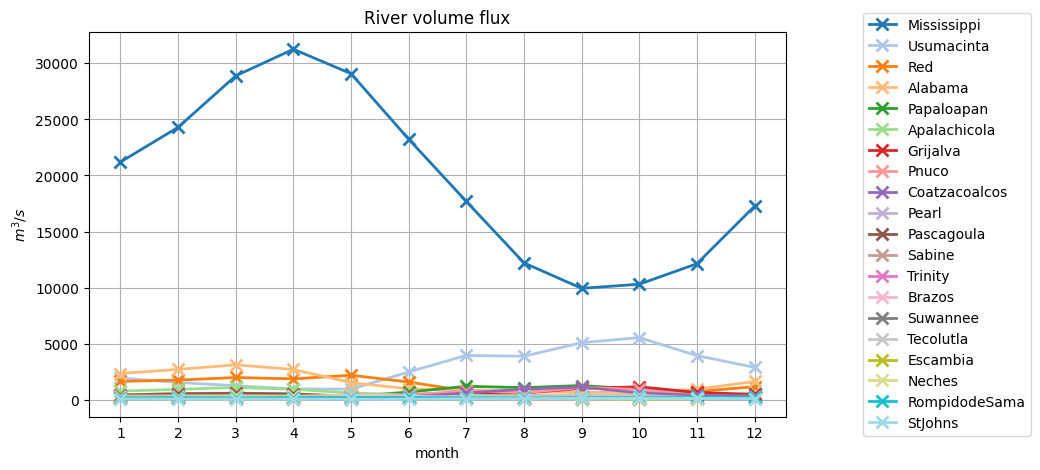

In [49]:
river_forcing.plot("river_volume")

Finally, we save the river forcing to NetCDF and YAML files.

In [50]:
river_forcing.save(target_dir / "roms_rivers.nc")

2025-09-29 14:10:58 - INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_rivers.nc


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_rivers.nc')]

In [51]:
river_forcing.to_yaml(target_dir / "roms_rivers.yaml")

You can find more information about creating, plotting, and saving river forcing [here](https://roms-tools.readthedocs.io/en/latest/river_forcing.html).

### Carbon Dioxide Removal (CDR) Forcing
Lastly, we create CDR forcing for our simulation.

In [52]:
from roms_tools import TracerPerturbation, CDRForcing

We first define a tracer perturbation release, which perturbs the BGC tracer fields without adding water. This approach is suitable for large-scale applications where mixing has already occurred, such as in a pre-run mixing model.

The perturbation is centered at 28°N, 96°W, and at the surface (0 m depth). It is distributed using a Gaussian with standard deviations of 100 km horizontally and 50 m vertically. We release an alkalinity flux of 2,000,000 meq/s over the entire simulation period.

In [53]:
release = TracerPerturbation(
    name="OAE",
    lat=28,  # degree N
    lon=-96,  # degree E
    depth=0,  # m
    hsc=100000, # m
    vsc=50,  # m
    tracer_fluxes={"ALK": 2 * 10**6},  # meq/s
)

For more complex, time-varying releases, or releases that add water in addition to perturbing tracers (relevant for field-scale deployments where mixing is still required), see this [page](https://roms-tools.readthedocs.io/en/latest/cdr_forcing.html).

We now assemble all releases that we want to run in a single simulations into the CDR forcing.

In [54]:
cdr_forcing = CDRForcing(
    grid=grid,
    start_time=start_time, # simulation start time
    end_time=end_time, # simulation end time
    releases=[release]
)

We can make a plot of the release distribution.

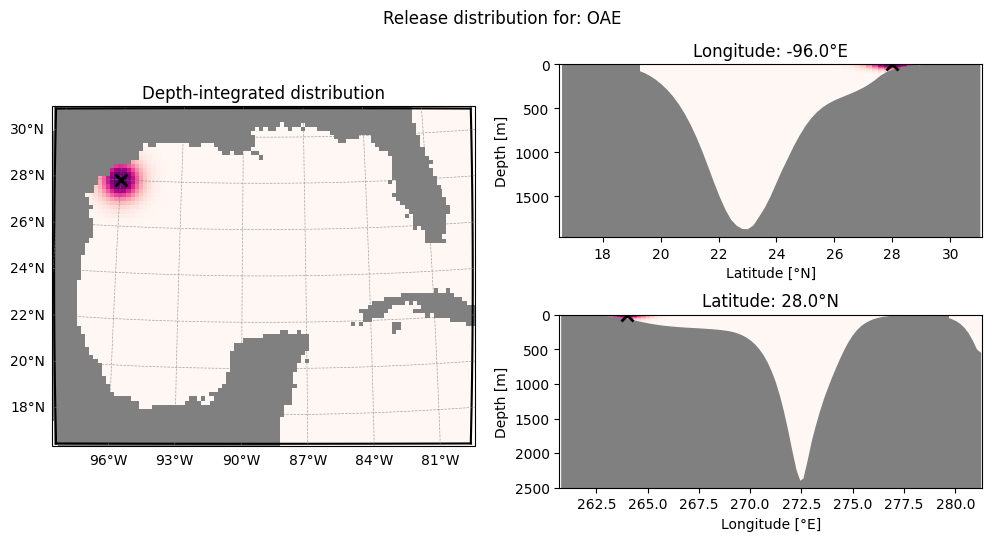

In [55]:
cdr_forcing.plot_distribution(release_name="OAE")

Here is a plot of the alkalinity flux being released, which is constant over time.

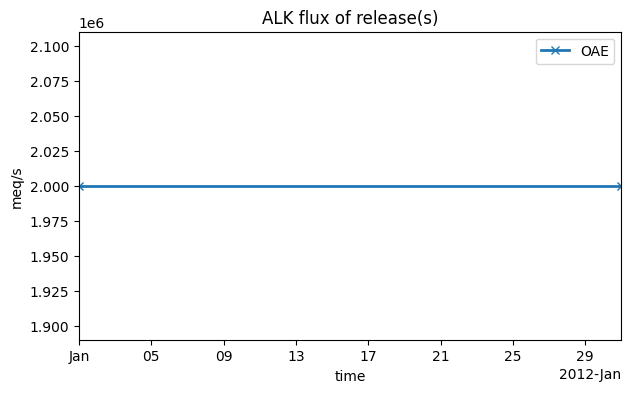

In [56]:
cdr_forcing.plot_tracer_flux(tracer_name="ALK")

Finally, we save the CDR forcing to NetCDF and YAML files.

In [57]:
cdr_forcing.save(target_dir / "roms_cdr.nc")

2025-09-29 14:11:08 - INFO - Writing the following NetCDF files:
ROMS_TOOLS_INPUT_DATA/roms_cdr.nc


[PosixPath('ROMS_TOOLS_INPUT_DATA/roms_cdr.nc')]

In [58]:
cdr_forcing.to_yaml(target_dir / "roms_cdr.yaml")

## Running ROMS

In the last section we have made all necessary input fields. We are now ready to run a ROMS-MARBL simulation!

Here we run a pre-compiled version of ROMS using a container. Containers can be used to run programs in portable, reproducible pre-configured environments.

Let's first make a directory that will hold the model output.

In [59]:
from pathlib import Path

In [60]:
output_dir = Path("./OUTPUT")

In [61]:
output_dir.mkdir(exist_ok=True)

Next, users on MacOS must first initialise a virtual machine. Make sure that `podman` is installed, as noted at the top of the notebook.

In [62]:
import os

In [63]:
os.environ["PATH"] = "/opt/podman/bin:" + os.environ["PATH"]

In [64]:
%%bash

podman machine init --cpus 10
podman machine start

Error: podman-machine-default: VM already exists


Starting machine "podman-machine-default"

This machine is currently configured in rootless mode. If your containers
require root permissions (e.g. ports < 1024), or if you run into compatibility
issues with non-podman clients, you can switch using the following command:

	podman machine set --rootful

API forwarding listening on: /var/run/docker.sock
Docker API clients default to this address. You do not need to set DOCKER_HOST.

Machine "podman-machine-default" started successfully


We have built a [container for this example](https://github.com/orgs/CWorthy-ocean/packages/container/package/roms_tools_end_to_end_example) that is available through the GitHub Container Repository. Let's pull this container image!

In [65]:
%%bash

podman pull ghcr.io/cworthy-ocean/roms_tools_end_to_end_example:latest > /dev/null 2>&1

In the above cell, the `> /dev/null 2>&1` part suppresses all output. Remove it if you want to see the download progress and logs.

Now we can run the container with the following flags:

* `--rm`: automatically remove the container after it finishes
* `-v`: mount directories for input files and output so ROMS-MARBL can access inputs and save results

We prefix the command with `time` to measure how long the simulation takes to run.

In [66]:
%%bash

podman run --rm -v ./ROMS_TOOLS_INPUT_DATA:/input -v ./OUTPUT:/output ghcr.io/cworthy-ocean/roms_tools_end_to_end_example:latest > /dev/null 2>&1

Again, the `> /dev/null 2>&1` part suppresses all output. Remove it if you want to see the full (and very long) ROMS model output.

## Analyzing the output
The output is now in the `OUTPUT` directory that we created.

In [67]:
ls OUTPUT/

ROMS_example_cstar.20120102000000.nc  ROMS_example_his.20120101000000.nc


The `ROMS_example_his*.nc` files contain snapshots of the physical variables, while the `ROMS_example_cstar*.nc` files hold the CDR-related output.

We can visualize the output with `ROMS-Tools`.

In [68]:
from roms_tools import ROMSOutput

In [69]:
roms_output = ROMSOutput(
    grid=grid,
    path="OUTPUT/ROMS_example_his.20120101000000.nc",
    use_dask=True,
)

This output contains 31 snapshots, one per day.

In [70]:
roms_output.ds

<xarray.Dataset> Size: 86MB
Dimensions:     (time: 31, auxil: 6, eta_rho: 82, xi_rho: 102, xi_u: 101,
                 eta_v: 81, s_rho: 20)
Coordinates:
    abs_time    (time) datetime64[ns] 248B 2012-01-01 2012-01-02 ... 2012-01-31
    lat_rho     (eta_rho, xi_rho) float64 67kB 16.43 16.44 16.46 ... 30.94 30.93
    lon_rho     (eta_rho, xi_rho) float64 67kB 261.6 261.8 262.0 ... 281.3 281.5
    lat_u       (eta_rho, xi_u) float64 66kB 16.44 16.45 16.46 ... 30.95 30.93
    lon_u       (eta_rho, xi_u) float64 66kB 261.7 261.9 262.1 ... 281.2 281.4
    lat_v       (eta_v, xi_rho) float64 66kB 16.52 16.53 16.55 ... 30.85 30.84
    lon_v       (eta_v, xi_rho) float64 66kB 261.6 261.8 262.0 ... 281.3 281.5
Dimensions without coordinates: time, auxil, eta_rho, xi_rho, xi_u, eta_v, s_rho
Data variables:
    ocean_time  (time) float64 248B dask.array<chunksize=(1,), meta=np.ndarray>
    time_step   (time, auxil) int32 744B dask.array<chunksize=(1, 6), meta=np.ndarray>
    zeta        (time, eta_rho, xi_rho) float32 1MB dask.array<chunksize=(1, 82, 102), meta=np.ndarray>
    ubar        (time, eta_rho, xi_u) float32 1MB dask.array<chunksize=(1, 82, 101), meta=np.ndarray>
    vbar        (time, eta_v, xi_rho) float32 1MB dask.array<chunksize=(1, 81, 102), meta=np.ndarray>
    u           (time, s_rho, eta_rho, xi_u) float32 21MB dask.array<chunksize=(1, 20, 82, 101), meta=np.ndarray>
    v           (time, s_rho, eta_v, xi_rho) float32 20MB dask.array<chunksize=(1, 20, 81, 102), meta=np.ndarray>
    temp        (time, s_rho, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 20, 82, 102), meta=np.ndarray>
    salt        (time, s_rho, eta_rho, xi_rho) float32 21MB dask.array<chunksize=(1, 20, 82, 102), meta=np.ndarray>
Attributes: (12/44)
    global_x:           100
    global_y:           80
    title:              Example run
    grid_file:          ROMS_TOOLS_INPUT_DATA/roms_grd.0.nc
    forcing_files:       ROMS_TOOLS_INPUT_DATA/roms_frc_201201.0.nc ROMS_TOOL...
    forcing_info:       
    ...                 ...
    tide_options:       OFF
    river_frc_options:  OFF
    pipe_frc_options:   OFF
    particle_options:   OFF
    git_version:        eeaca4861898a27443cd1f693811c321140ef58c
    type:               ROMS history file

Let’s plot the sea surface temperature at the start of the simulation (January 1, 2012) and again 31 days later.

[########################################] | 100% Completed | 106.28 ms


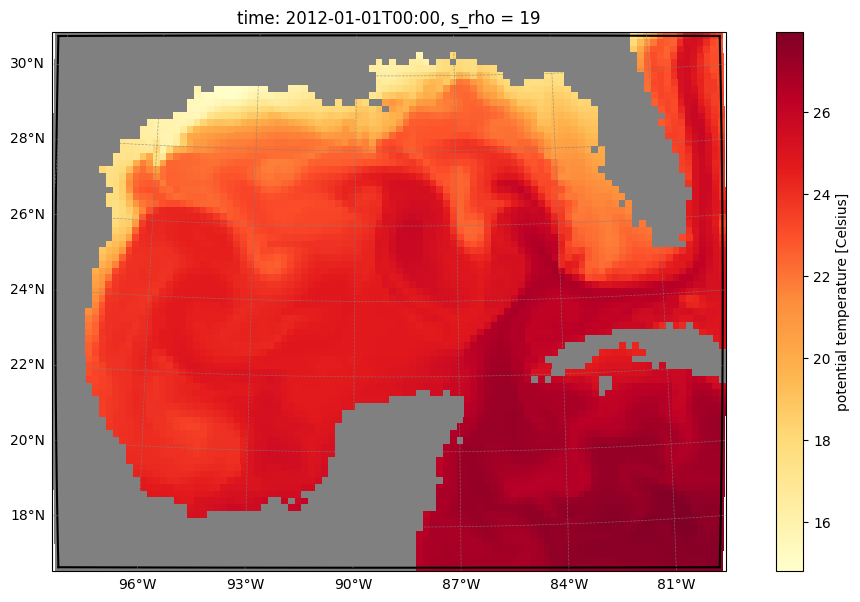

In [71]:
roms_output.plot("temp", s=-1, time=0)

[########################################] | 100% Completed | 103.00 ms


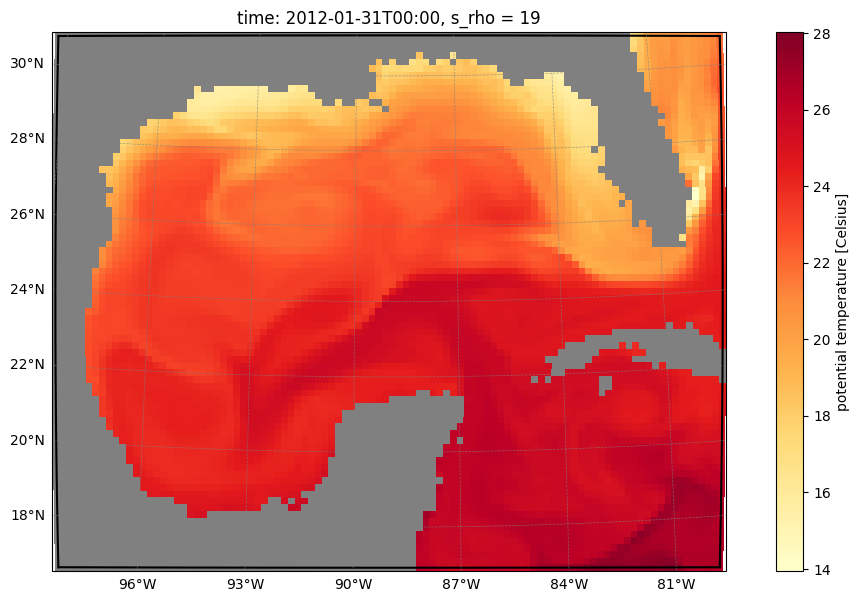

In [72]:
roms_output.plot("temp", s=-1, time=-1)

We can also compare zonal surface velocity at the start of the simulation and 31 days later.

[########################################] | 100% Completed | 106.18 ms


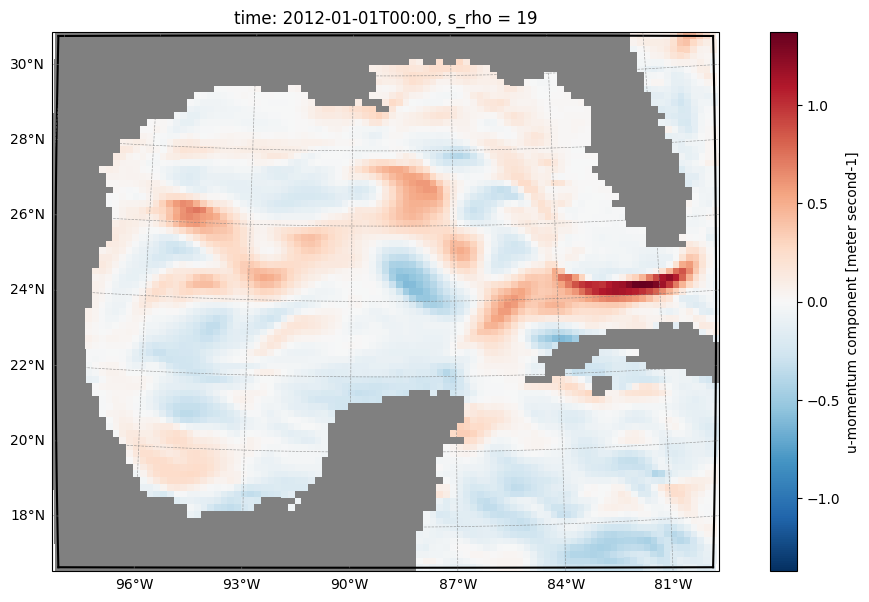

In [73]:
roms_output.plot("u", s=-1, time=0)

[########################################] | 100% Completed | 105.55 ms


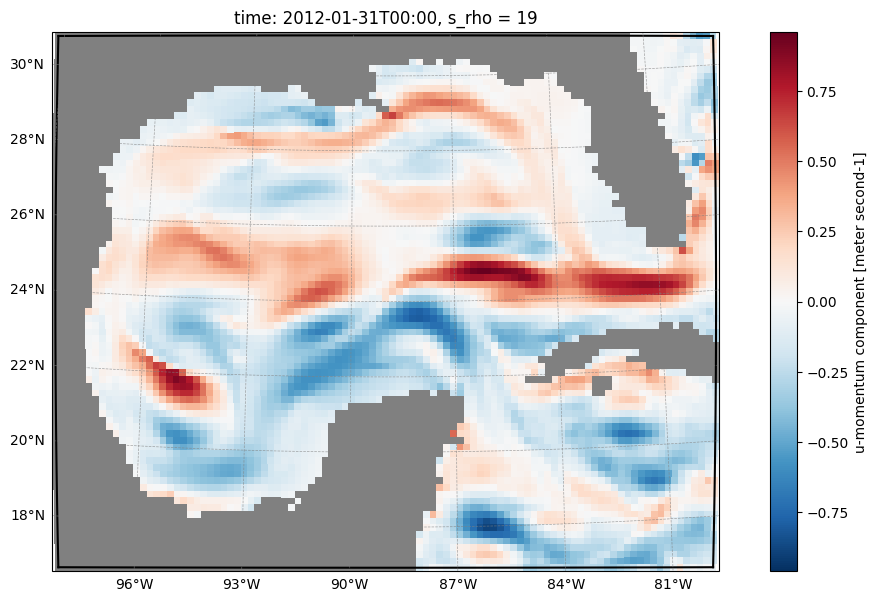

In [74]:
roms_output.plot("u", s=-1, time=-1)

You can learn more about visualizing ROMS output [here](https://roms-tools.readthedocs.io/en/latest/plotting_roms_output.html).

Let's now have a look at the CDR-related output.

In [75]:
cdr_roms_output = ROMSOutput(
    grid=grid,
    path="OUTPUT/ROMS_example_cstar.20120102000000.nc",
    use_dask=True,
)

This output contains 30 time stamps, each representing a daily average.

In [76]:
cdr_roms_output.ds

<xarray.Dataset> Size: 649MB
Dimensions:         (time: 30, eta_rho: 82, xi_rho: 102, s_rho: 20)
Coordinates:
    abs_time        (time) datetime64[ns] 240B 2012-01-02 ... 2012-01-31
    lat_rho         (eta_rho, xi_rho) float64 67kB 16.43 16.44 ... 30.94 30.93
    lon_rho         (eta_rho, xi_rho) float64 67kB 261.6 261.8 ... 281.3 281.5
Dimensions without coordinates: time, eta_rho, xi_rho, s_rho
Data variables: (12/22)
    ocean_time      (time) float64 240B dask.array<chunksize=(1,), meta=np.ndarray>
    zeta            (time, eta_rho, xi_rho) float64 2MB dask.array<chunksize=(1, 82, 102), meta=np.ndarray>
    temp            (time, s_rho, eta_rho, xi_rho) float64 40MB dask.array<chunksize=(1, 20, 82, 102), meta=np.ndarray>
    salt            (time, s_rho, eta_rho, xi_rho) float64 40MB dask.array<chunksize=(1, 20, 82, 102), meta=np.ndarray>
    ALK             (time, s_rho, eta_rho, xi_rho) float64 40MB dask.array<chunksize=(1, 20, 82, 102), meta=np.ndarray>
    DIC             (time, s_rho, eta_rho, xi_rho) float64 40MB dask.array<chunksize=(1, 20, 82, 102), meta=np.ndarray>
    ...              ...
    ALK_source      (time, s_rho, eta_rho, xi_rho) float64 40MB dask.array<chunksize=(1, 20, 82, 102), meta=np.ndarray>
    ALK_ALT_source  (time, s_rho, eta_rho, xi_rho) float64 40MB dask.array<chunksize=(1, 20, 82, 102), meta=np.ndarray>
    DIC_source      (time, s_rho, eta_rho, xi_rho) float64 40MB dask.array<chunksize=(1, 20, 82, 102), meta=np.ndarray>
    DIC_ALT_source  (time, s_rho, eta_rho, xi_rho) float64 40MB dask.array<chunksize=(1, 20, 82, 102), meta=np.ndarray>
    avg_begin_time  (time) float64 240B dask.array<chunksize=(1,), meta=np.ndarray>
    avg_end_time    (time) float64 240B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/44)
    global_x:           100
    global_y:           80
    title:              Example run
    grid_file:          ROMS_TOOLS_INPUT_DATA/roms_grd.0.nc
    forcing_files:       ROMS_TOOLS_INPUT_DATA/roms_frc_201201.0.nc ROMS_TOOL...
    forcing_info:       
    ...                 ...
    tide_options:       OFF
    river_frc_options:  OFF
    pipe_frc_options:   OFF
    particle_options:   OFF
    git_version:        eeaca4861898a27443cd1f693811c321140ef58c
    averaging:          All variables are averaged in time

Here we show the alkalinity source term diagnosed online by the model, plotted at the surface for the first time step.

[########################################] | 100% Completed | 104.26 ms


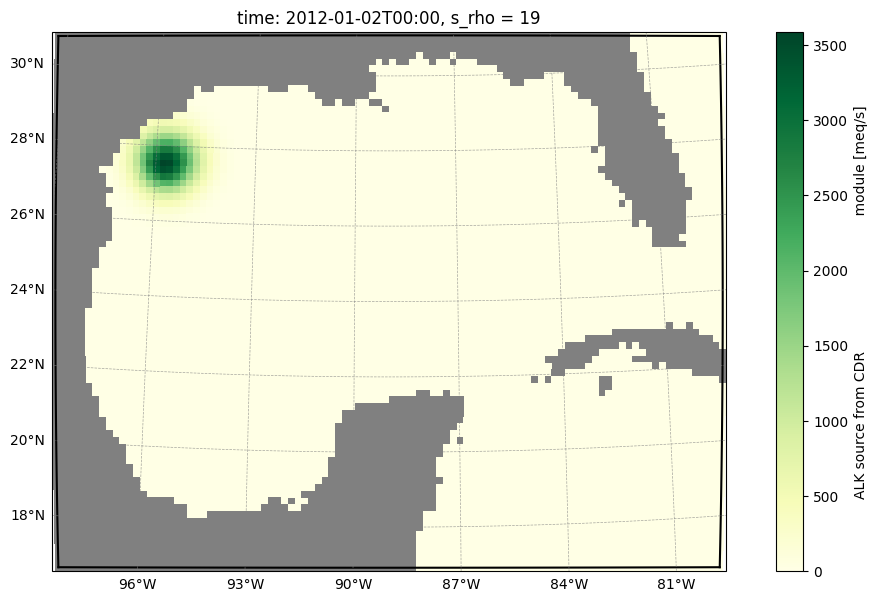

In [77]:
cdr_roms_output.plot("ALK_source", s=-1, time=0)

Finally, we compute the CDR uptake curves using two approaches: from CO₂ flux differences and from DIC differences. A more detailed explanation is provided [here](https://roms-tools.readthedocs.io/en/latest/cdr_analysis.html).

2025-09-29 16:08:22 - INFO - Max absolute difference between flux-based and DIC-based uptake efficiency: 4.559e-03


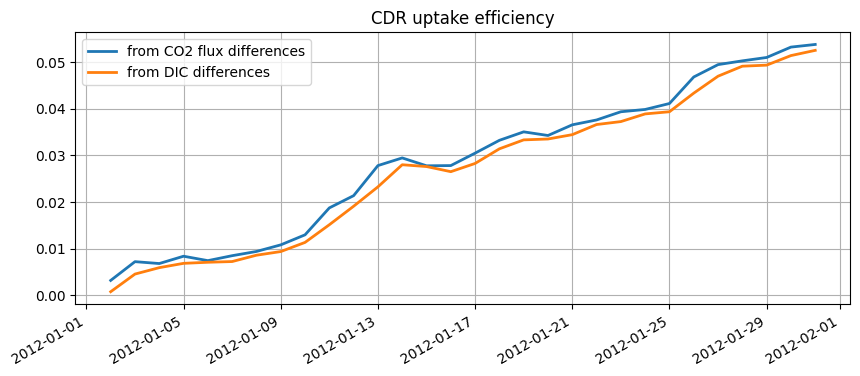

In [78]:
cdr_roms_output.cdr_metrics()

There are slight differences between the uptake curves depending on the computation method, but overall they agree closely. Since the simulation was run for only one month, the uptake efficiency remains relatively low, around 5% at the end of the period. Extending the simulation would allow the efficiency to increase further.

The computed CDR metrics can also be found in the `.ds_cdr` attribute.

In [79]:
cdr_roms_output.ds_cdr

<xarray.Dataset> Size: 85MB
Dimensions:                         (time: 30, eta_rho: 82, xi_rho: 102,
                                     s_rho: 20)
Coordinates:
    abs_time                        (time) datetime64[ns] 240B 2012-01-02 ......
    lat_rho                         (eta_rho, xi_rho) float64 67kB 16.43 ... ...
    lon_rho                         (eta_rho, xi_rho) float64 67kB 261.6 ... ...
Dimensions without coordinates: time, eta_rho, xi_rho, s_rho
Data variables:
    FG_CO2                          (time, eta_rho, xi_rho) float64 2MB dask.array<chunksize=(1, 82, 102), meta=np.ndarray>
    FG_ALT_CO2                      (time, eta_rho, xi_rho) float64 2MB dask.array<chunksize=(1, 82, 102), meta=np.ndarray>
    hDIC                            (time, s_rho, eta_rho, xi_rho) float64 40MB dask.array<chunksize=(1, 20, 82, 102), meta=np.ndarray>
    hDIC_ALT_CO2                    (time, s_rho, eta_rho, xi_rho) float64 40MB dask.array<chunksize=(1, 20, 82, 102), meta=np.ndarray>
    area                            (eta_rho, xi_rho) float64 67kB 3.938e+08 ...
    window_length                   (time) float64 240B dask.array<chunksize=(1,), meta=np.ndarray>
    cdr_efficiency                  (time) float64 240B dask.array<chunksize=(1,), meta=np.ndarray>
    cdr_efficiency_from_delta_diff  (time) float64 240B dask.array<chunksize=(1,), meta=np.ndarray>

Learn more about analyzing CDR metrics [here](https://roms-tools.readthedocs.io/en/latest/cdr_analysis.html).